In [1]:
import numpy as num
import matplotlib.pyplot as plt
import scipy as sci
import astropy.io.ascii as ascii
#!pip install batman-package
import batman
#!pip install emcee
import emcee
#!pip install corner
import corner
import os
import multiprocessing as mp
mp.set_start_method('fork', force=True)
from multiprocessing import Pool
from sklearn.metrics import mean_squared_error
import datetime
import cc_transits

***
--> Modificar aquí lo que se necesite

--> Recordar que más adelante se debe modificar también la forma de la baseline y los valores de los parámetros
***

In [2]:
os.environ["OMP_NUM_THREADS"] = "4"
PAR = True  #Intentar paralelizar esto

In [3]:
PARAM_FILE = "TOI-XXXX.par"
AP = [22]    # Selected aperture
REF = [1]    # Selected reference star

FIT_b = False # Fit b (True) or inc (Falase) in MCMC

MCMC_nsteps = 20000
MCMC_burnin = 10000
MCMC_nwalkers = 64

t_min = 0.610   # Minimun fractional time to include in fit (0.0 to include all)
t_max = 0.817   # Maximum fractional time to include in fit (1.0 to include all)

***
***

In [4]:
par = cc_transits.read_paramfile(PARAM_FILE)
target       = par.target
instrument = par.instrument
obsdate    = par.obsdate
selec      = par.selec
dir_imgs = "../imagenes/%s/%s"%(instrument,obsdate)
dir_cal  = "%s/calibrated/%s/%s"%(dir_imgs, target, selec)
dir_phot = "../photometry/%s/%s/%s/%s"%(instrument,obsdate,target,selec)

Opening parameter file TOI-4562b_PdosD.par


In [5]:
PATH = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')
os.makedirs(PATH)

In [6]:
plt.rcParams['figure.figsize'] = 4,2
plt.rcParams['figure.dpi'] = 300

In [7]:
def transit_lightcurve(t, rp=0.1, a=15.0, inc=88.0, fit_b=False, b=0.0, per=2.0, t0=0.0, ecc=0.0, w=90.0, u=[0.1, 0.3], limb_dark="quadratic",**kwd):
    params = batman.TransitParams()
    params.t0 = t0                       #time of inferior conjunction
    params.per = per                     #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = a                         #semi-major axis (in units of stellar radii)
    params.ecc = ecc                     #eccentricity
    params.w = w                         #longitude of periastron (in degrees)
    params.u = u                         #limb darkening coefficients [u1, u2]
    params.limb_dark = limb_dark         #limb darkening model 
    if fit_b:
        params.inc = num.arccos(b/a)*180.0/num.pi
    else:
        params.inc = inc                 #orbital inclination (in degrees)
    m = batman.TransitModel(params, t)
    flux = m.light_curve(params)
    return flux

In [8]:
def chi2(p,model,x,y,sig):
  return num.sum(((y - model(p,x)) / sig)**2)

In [9]:
def logL(p,model,x,y,sig):
  return -0.5*chi2(p,model,x,y,sig) - num.log(sig).sum()

# We can also create a simple uniform posterior distribution by limiting the parameter space
def logP(p,*args):
  if p[0] < 0 or p[0] > 1: return -num.inf
  if p[1] < 0: return -num.inf
  if p[2] < 0: return -num.inf
  if FIT_b:
    if p[3] < 0 or p[3] > 1: return -num.inf
  else:
    if p[3] < 0 or p[3] > 90.0: return -num.inf
  return logL(p,*args)

Read 340 photometry points


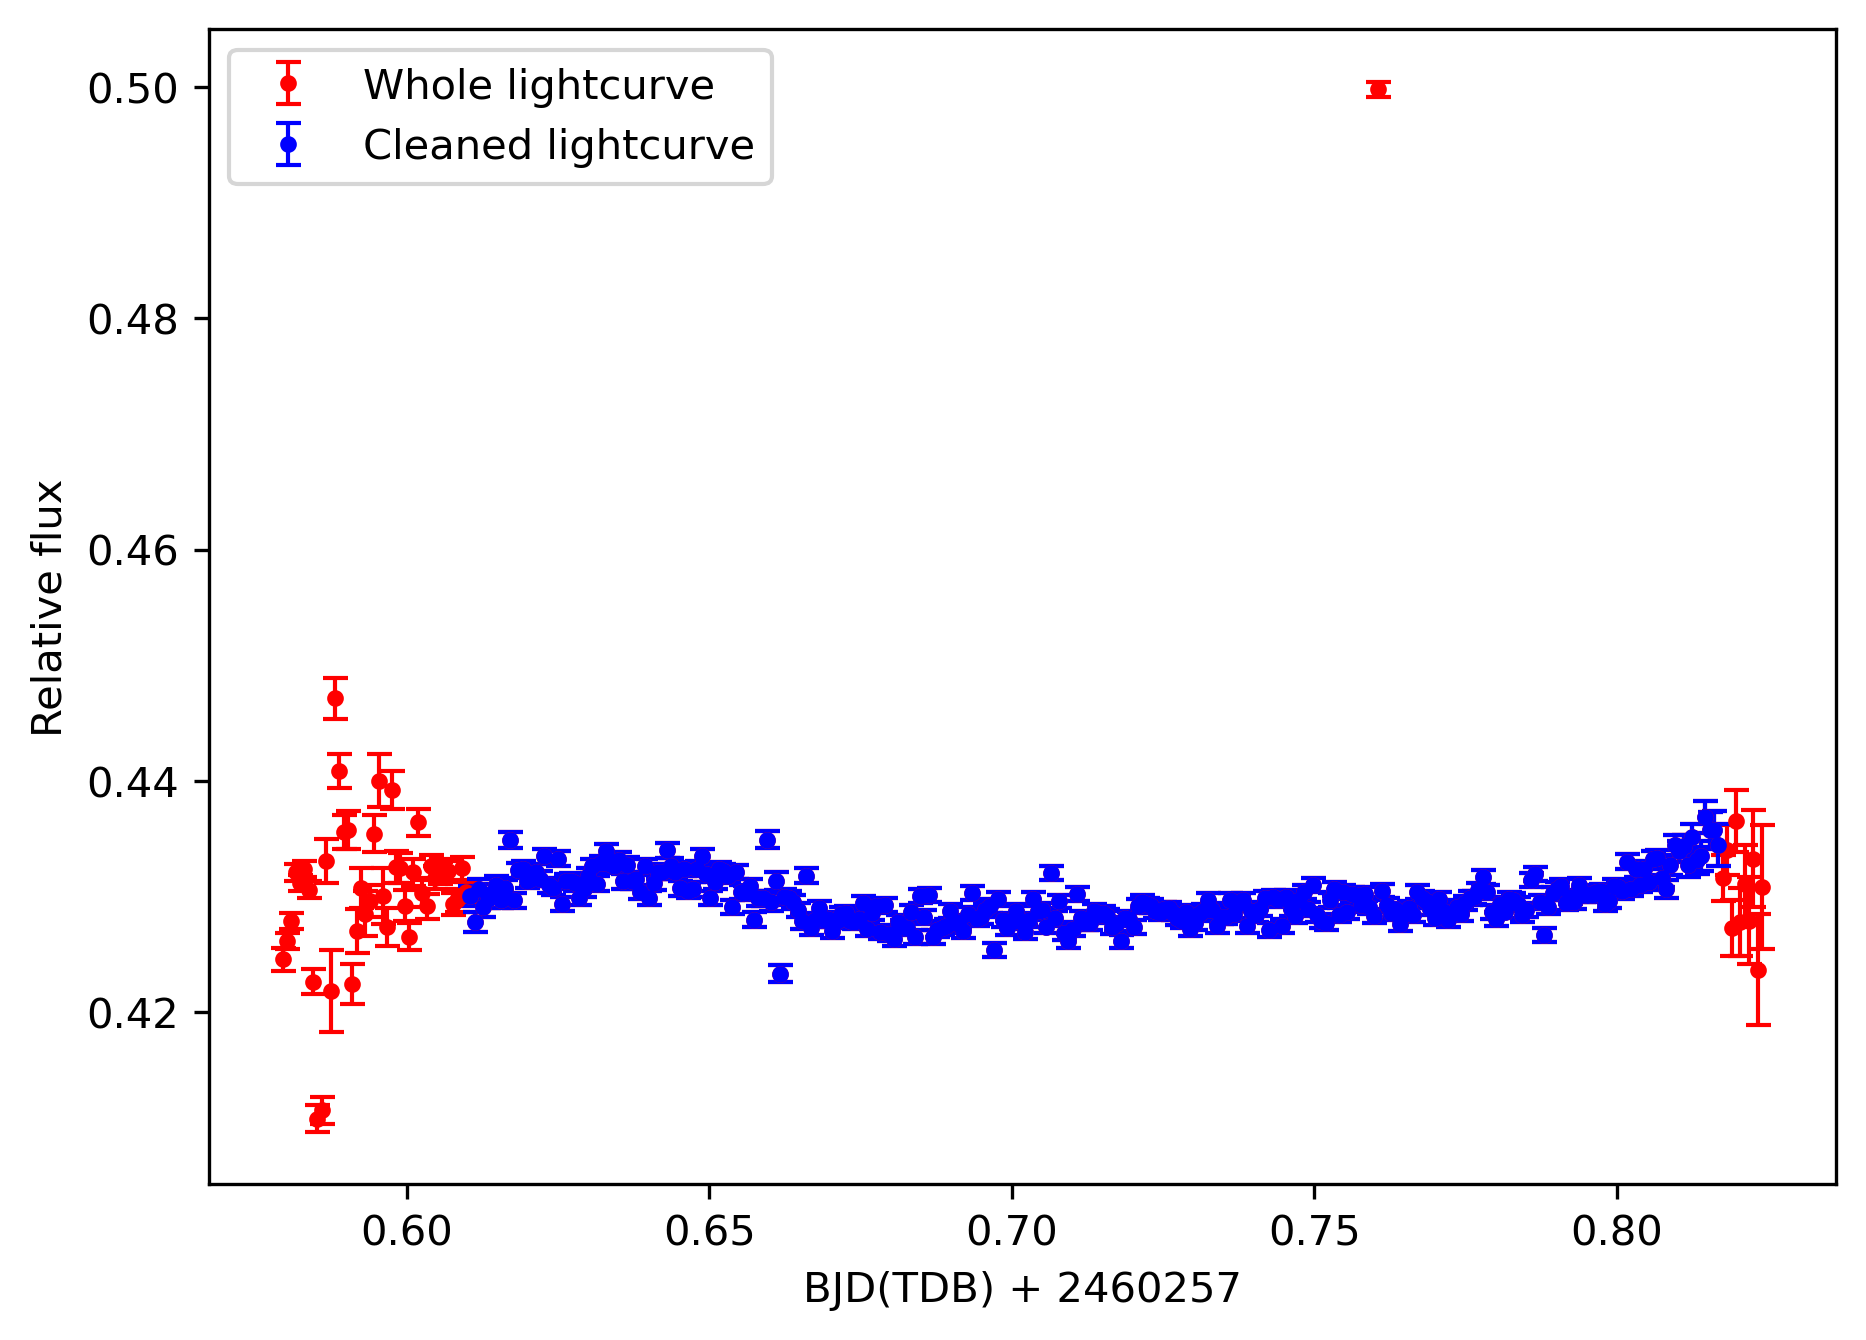

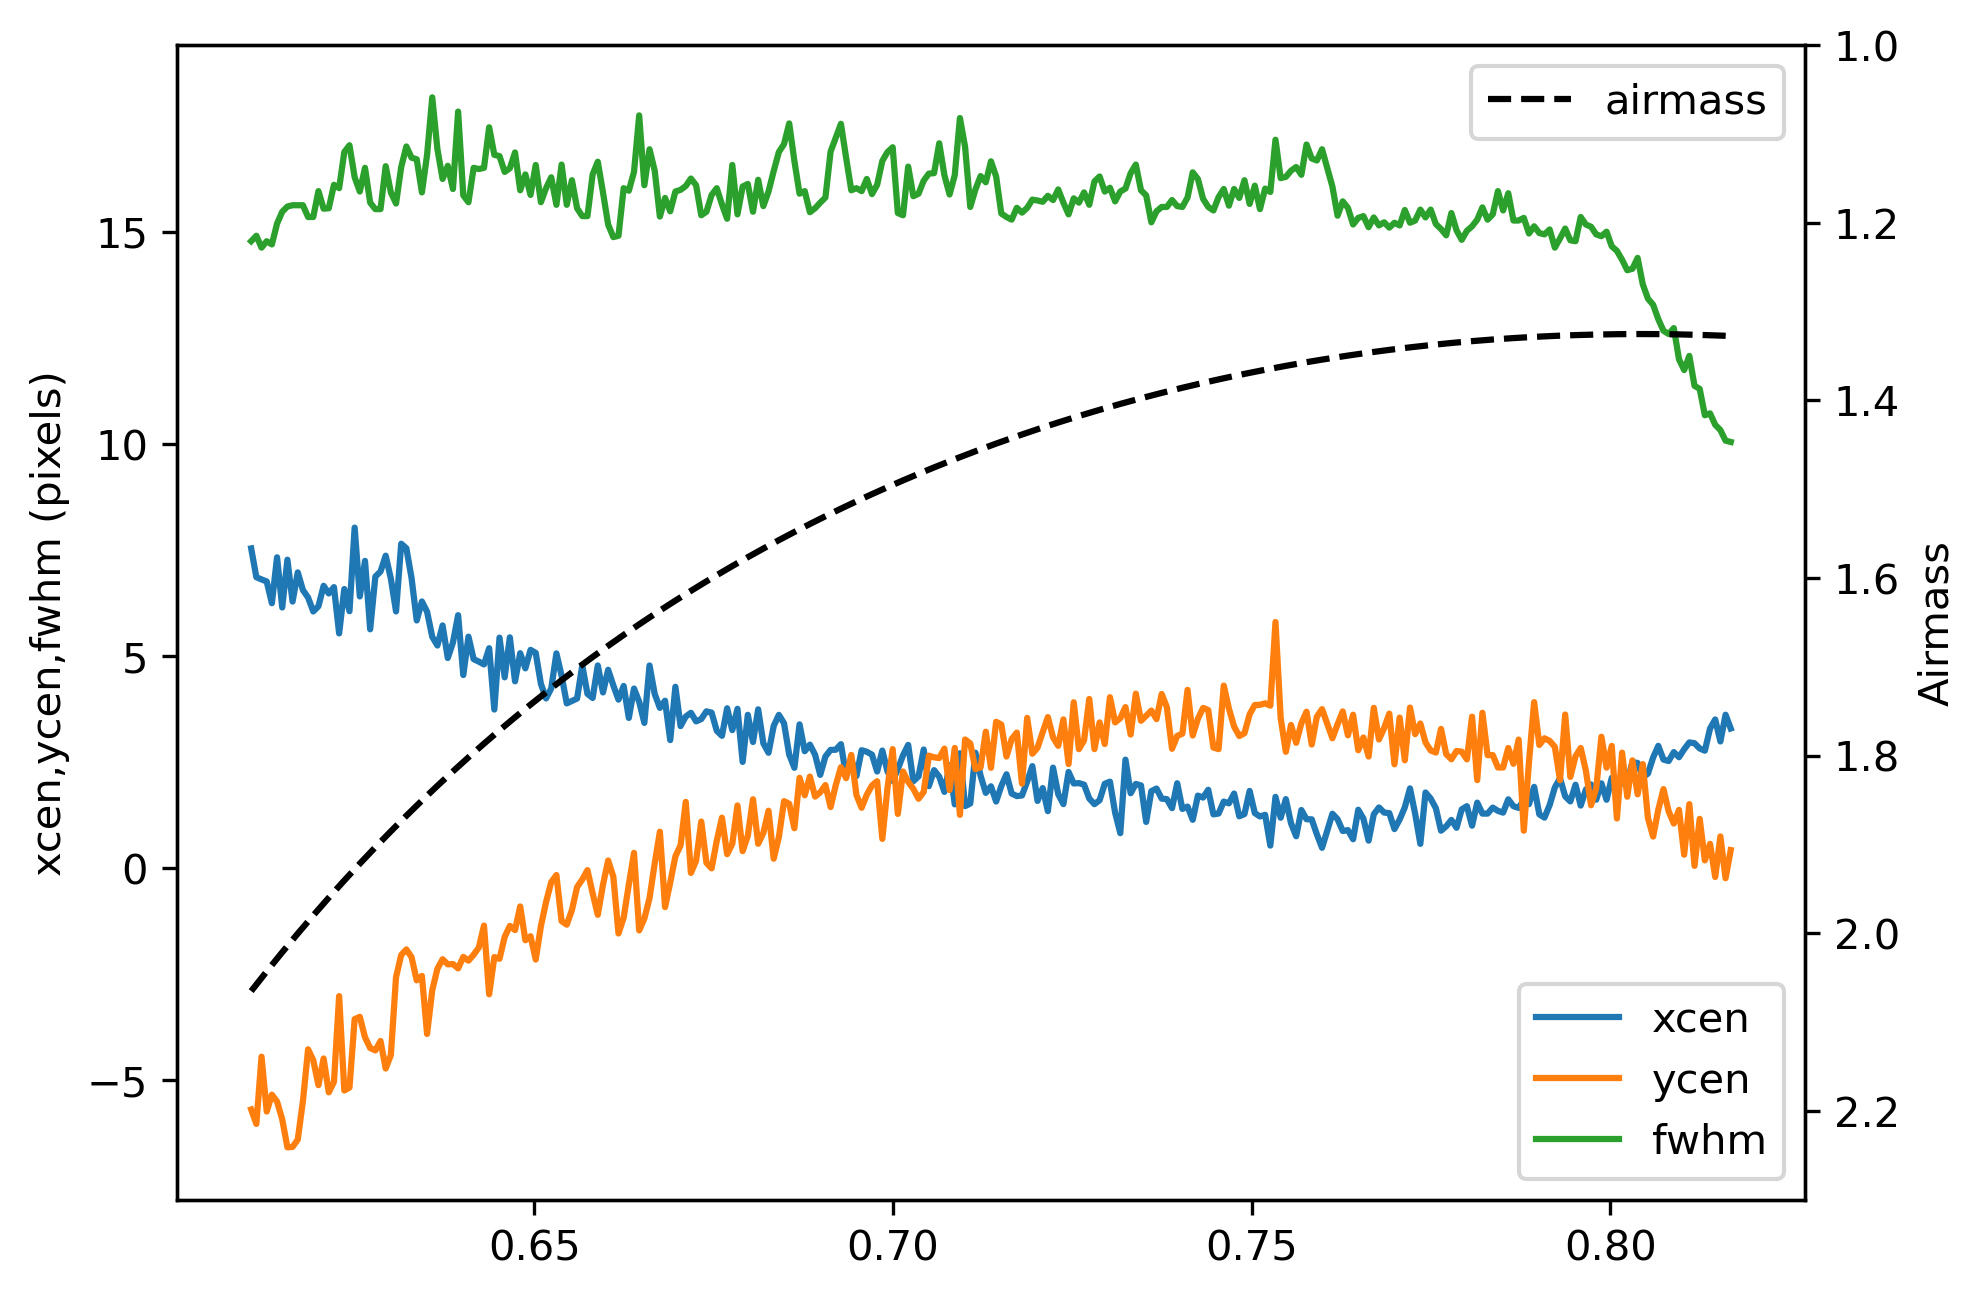

In [10]:
fig1 = plt.figure(figsize=(7,5))
fig2 = plt.figure(figsize=(7,5))
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax3 = ax2.twinx()
#ax4 = ax2.twinx()
for i in range(len(AP)):
    pars_file = "%s/parameters_star%d.dat"%(dir_phot,0)
    for j in range(len(REF)):
        phot_file = "%s/lightcurves_ap%.1f.dat"%(dir_phot,AP[i])
        #pars_file = "%s/parameters_star%d.dat"%(dir_phot,REF[j])
        phot = num.loadtxt(phot_file)
        pars = ascii.read(pars_file)
        t0 = phot[0,0]
        time = phot[:,1]
        flux = phot[:,1+2*REF[j]-1]
        dflux = phot[:,1+2*REF[j]]
        ibl1 = num.logical_and(time >= t_min, time <= t_max)
        f_med = num.median(flux[ibl1])
        f_std = num.std(flux[ibl1])
        ibl2 = num.logical_and(flux<f_med+5*f_std, flux>f_med-5*f_std)
        ibl = num.logical_and(ibl1, ibl2)
        #f = flux.copy()
        npoints = len(phot)
        print("Read %d photometry points"%npoints)
        ax1.errorbar(time,flux, yerr=dflux, fmt='o', capsize=3, ms=3, lw=1, color='red', label="Whole lightcurve")
        # Removing 5-sigma outlayers
        time = time[ibl]
        flux = flux[ibl]
        dflux = dflux[ibl]
        pars = pars[ibl]
        ax1.errorbar(time,flux, yerr=dflux, fmt='o', capsize=3, ms=3, lw=1, color='blue', label="Cleaned lightcurve")
        ax1.set_xlabel("BJD(TDB) + %.0f"%t0)
        ax1.set_ylabel("Relative flux")
ax2.plot(time,pars['xcen']-pars['xcen'].mean()+3.0, label="xcen")
ax2.plot(time,pars['ycen']-pars['ycen'].mean()+1.0, label="ycen")
ax2.set_ylabel("xcen,ycen,fwhm (pixels)")
ax2.plot(time,pars['fwhm'], label="fwhm")
ax3.plot(time,pars['airmass'], '--k', label="airmass")
ax3.set_ylabel("Airmass")
ax3.set_ylim(2.3, 1)
ax1.legend()
ax2.legend()
ax3.legend()
fig1.savefig(PATH+"/fig0_lightcurve.png", dpi=300)
fig2.savefig(PATH+"/fig1_parameters.png", dpi=300)

Definimos una función que use un vector de parámetros como input y entregue la curva de luz, asumiendo una ley de limb-darkening quadrática:

In [11]:
airmass = pars['airmass']
fwhm = pars['fwhm']
xcen = pars['xcen']
ycen = pars['ycen']

***
--> Define here the "shape" of the baseline and the initial parameters for the fit
***

In [12]:
def model_baseline(p,t):
    return p[9] + p[10]*airmass + p[11]*fwhm + p[12]*xcen + p[13]*ycen

In [13]:
# Parámetros iniciales y parámetros a fitear
# Realizar el fit sólo sobre parámetros con e > 0
if FIT_b:
    p_names = ["rp", "per", "a", "b", "t0", "ecc", "w", "u1", "u2", "f0", "f_secz", "f_fwhm", "f_xc", "f_yc"]
    p = num.array([0.09980, 225.11781, 147.4, 0.6, 0.735, 0.76, 60.0, 0.28, 0.29, 0.3335, -0.0046, 0.000021, 0.000012, 0.00014])
    e = num.array([0.0, 0.0, 0.1, 0.1, 0.1, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1])
else:    
    p_names = ["rp", "per", "a", "inc", "t0", "ecc", "w", "u1", "u2", "f0", "f_secz", "f_fwhm", "f_xc", "f_yc"]
    p = num.array([0.09980, 225.11781, 147.4, 89.06, 0.735, 0.76, 60.0, 0.28, 0.29, 0.3335, -0.0046, 0.000021, 0.000012, 0.00014])
    e = num.array([0.1, 0.0, 0.0, 0.0, 0.1, 0, 0, 0, 0, 0.1, 0.1, 0.1, 0.1, 0.1])


In [14]:
def model_transit(p, t):
    return transit_lightcurve(t, rp=p[0], per=p[1], a=p[2], inc=p[3], b=p[3], fit_b=FIT_b, t0=p[4], ecc=p[5], w=p[6], u=[p[7], p[8]])

In [15]:
def transit_ldquad(p, t):
    return model_baseline(p, t) * model_transit(p, t)

***
***

Text(0, 0.5, 'Relative flux')

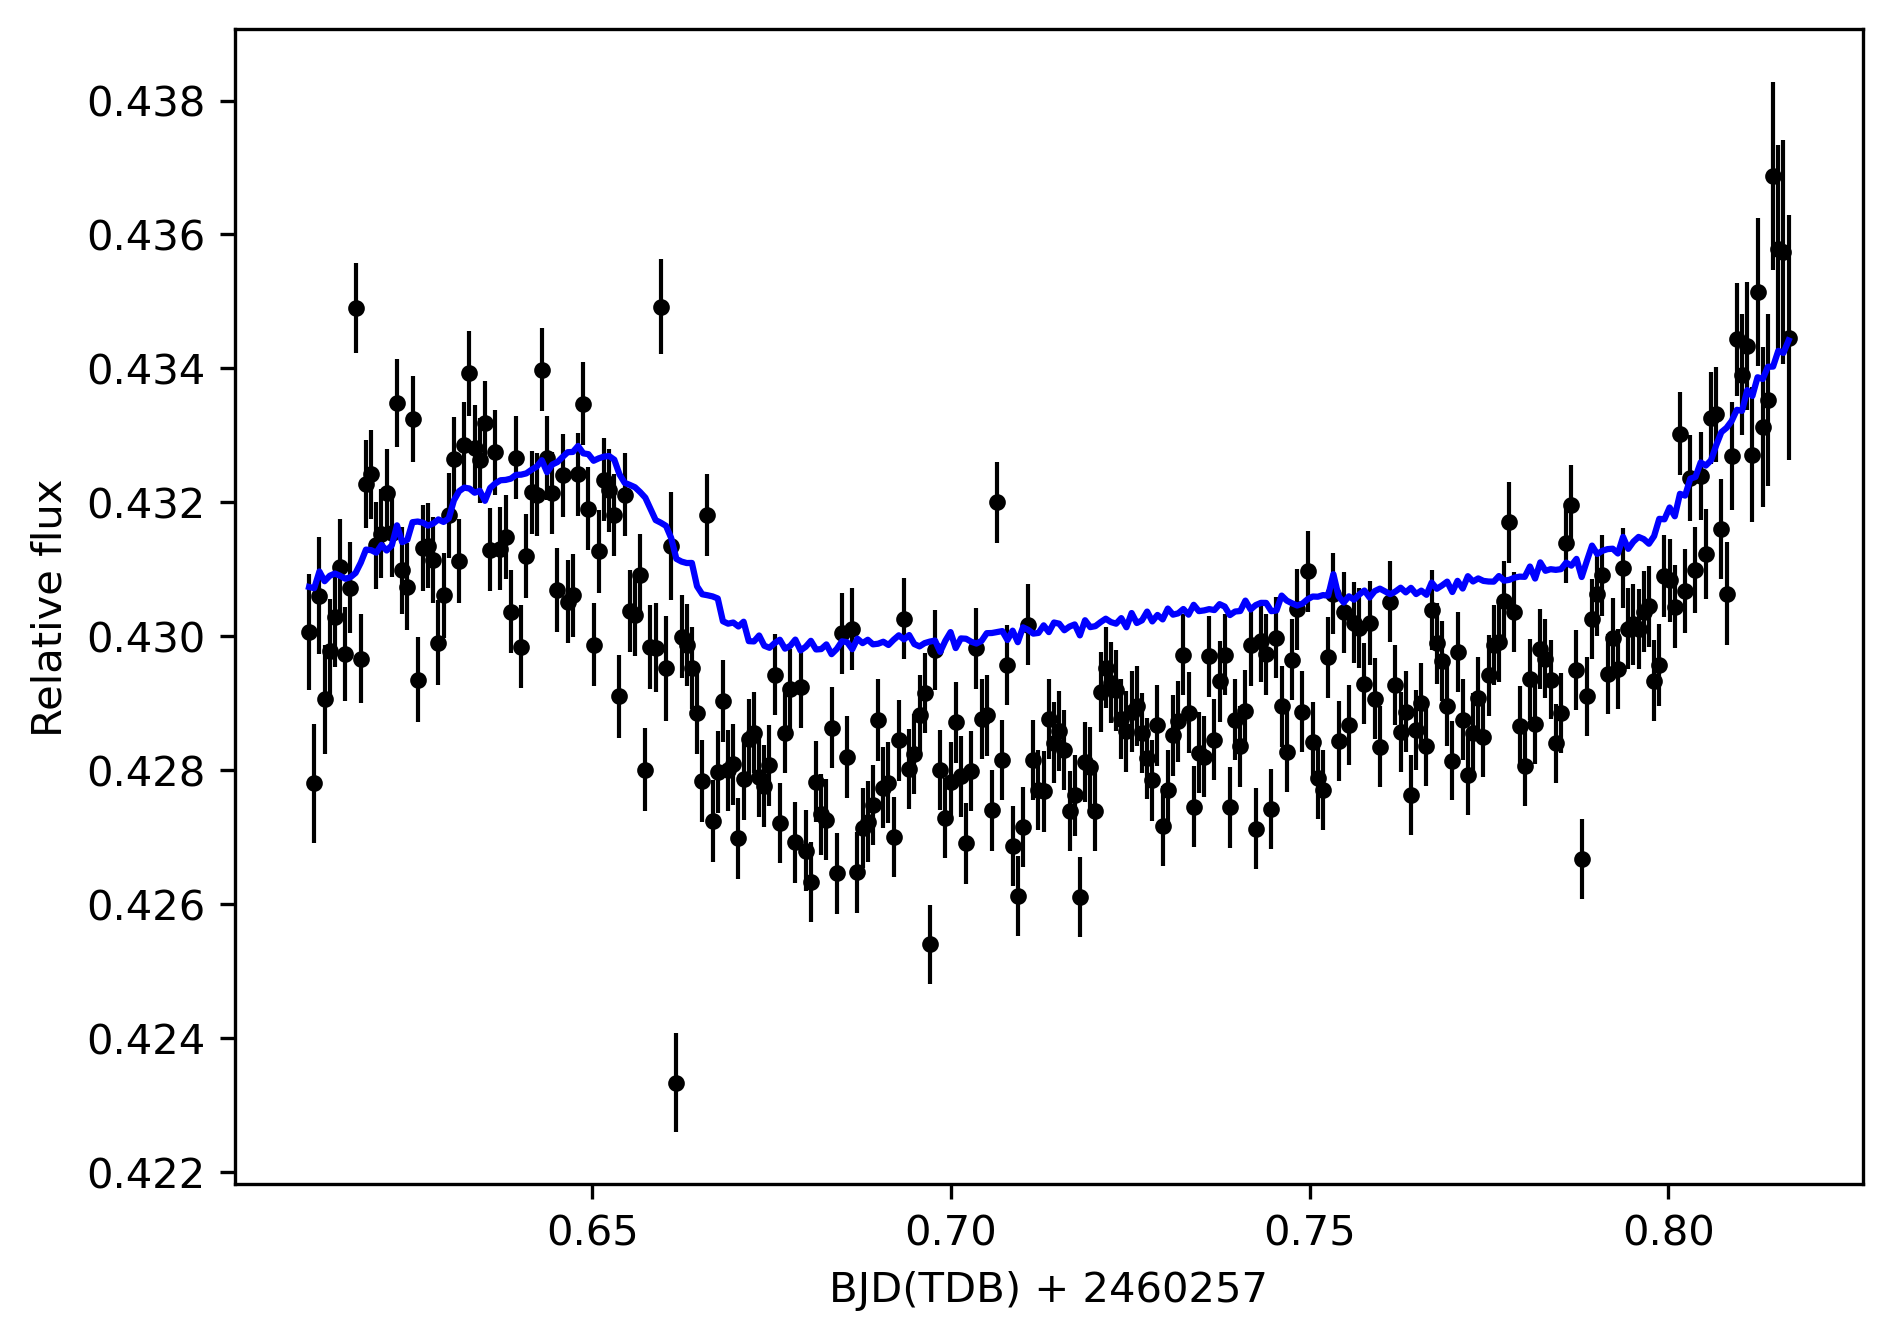

In [16]:
# Modelo inicial en ajuste
model_flux = transit_ldquad(p, time)
fig1 = plt.figure(figsize=(7,5))
ax0 = fig1.add_subplot()
ax0.errorbar(time,flux, yerr=dflux, fmt='o', color='black', capsize=0, ms=3, lw=1, zorder=0)
ax0.plot(time, model_flux, '-b')
ax0.set_xlabel("BJD(TDB) + %.0f"%t0)
ax0.set_ylabel("Relative flux")

In [17]:
def fminmax(func, x0, err=None, args=[], min=True, **kwargs):
    #if err==None:
    #    err = num.ones(x0.size)
    print(err)
    var_idx = err > 0
    x = num.copy(x0)
    def wrapper(p, *args):
        x[var_idx] = p
        if min: return func(x, *args)
        else: return -func(x, *args)
    x[var_idx] = sci.optimize.fmin(wrapper, p[var_idx], args=args, **kwargs)
    return x

[0.1 0.  0.  0.  0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1]
Optimization terminated successfully.
         Current function value: 961.078083
         Iterations: 539
         Function evaluations: 821
[0.1 0.  0.  0.  0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1]
Optimization terminated successfully.
         Current function value: -1622.034576
         Iterations: 136
         Function evaluations: 237
[0.1 0.  0.  0.  0.1 0.  0.  0.  0.  0.1 0.1 0.1 0.1 0.1]
Optimization terminated successfully.
         Current function value: -1622.034576
         Iterations: 136
         Function evaluations: 237


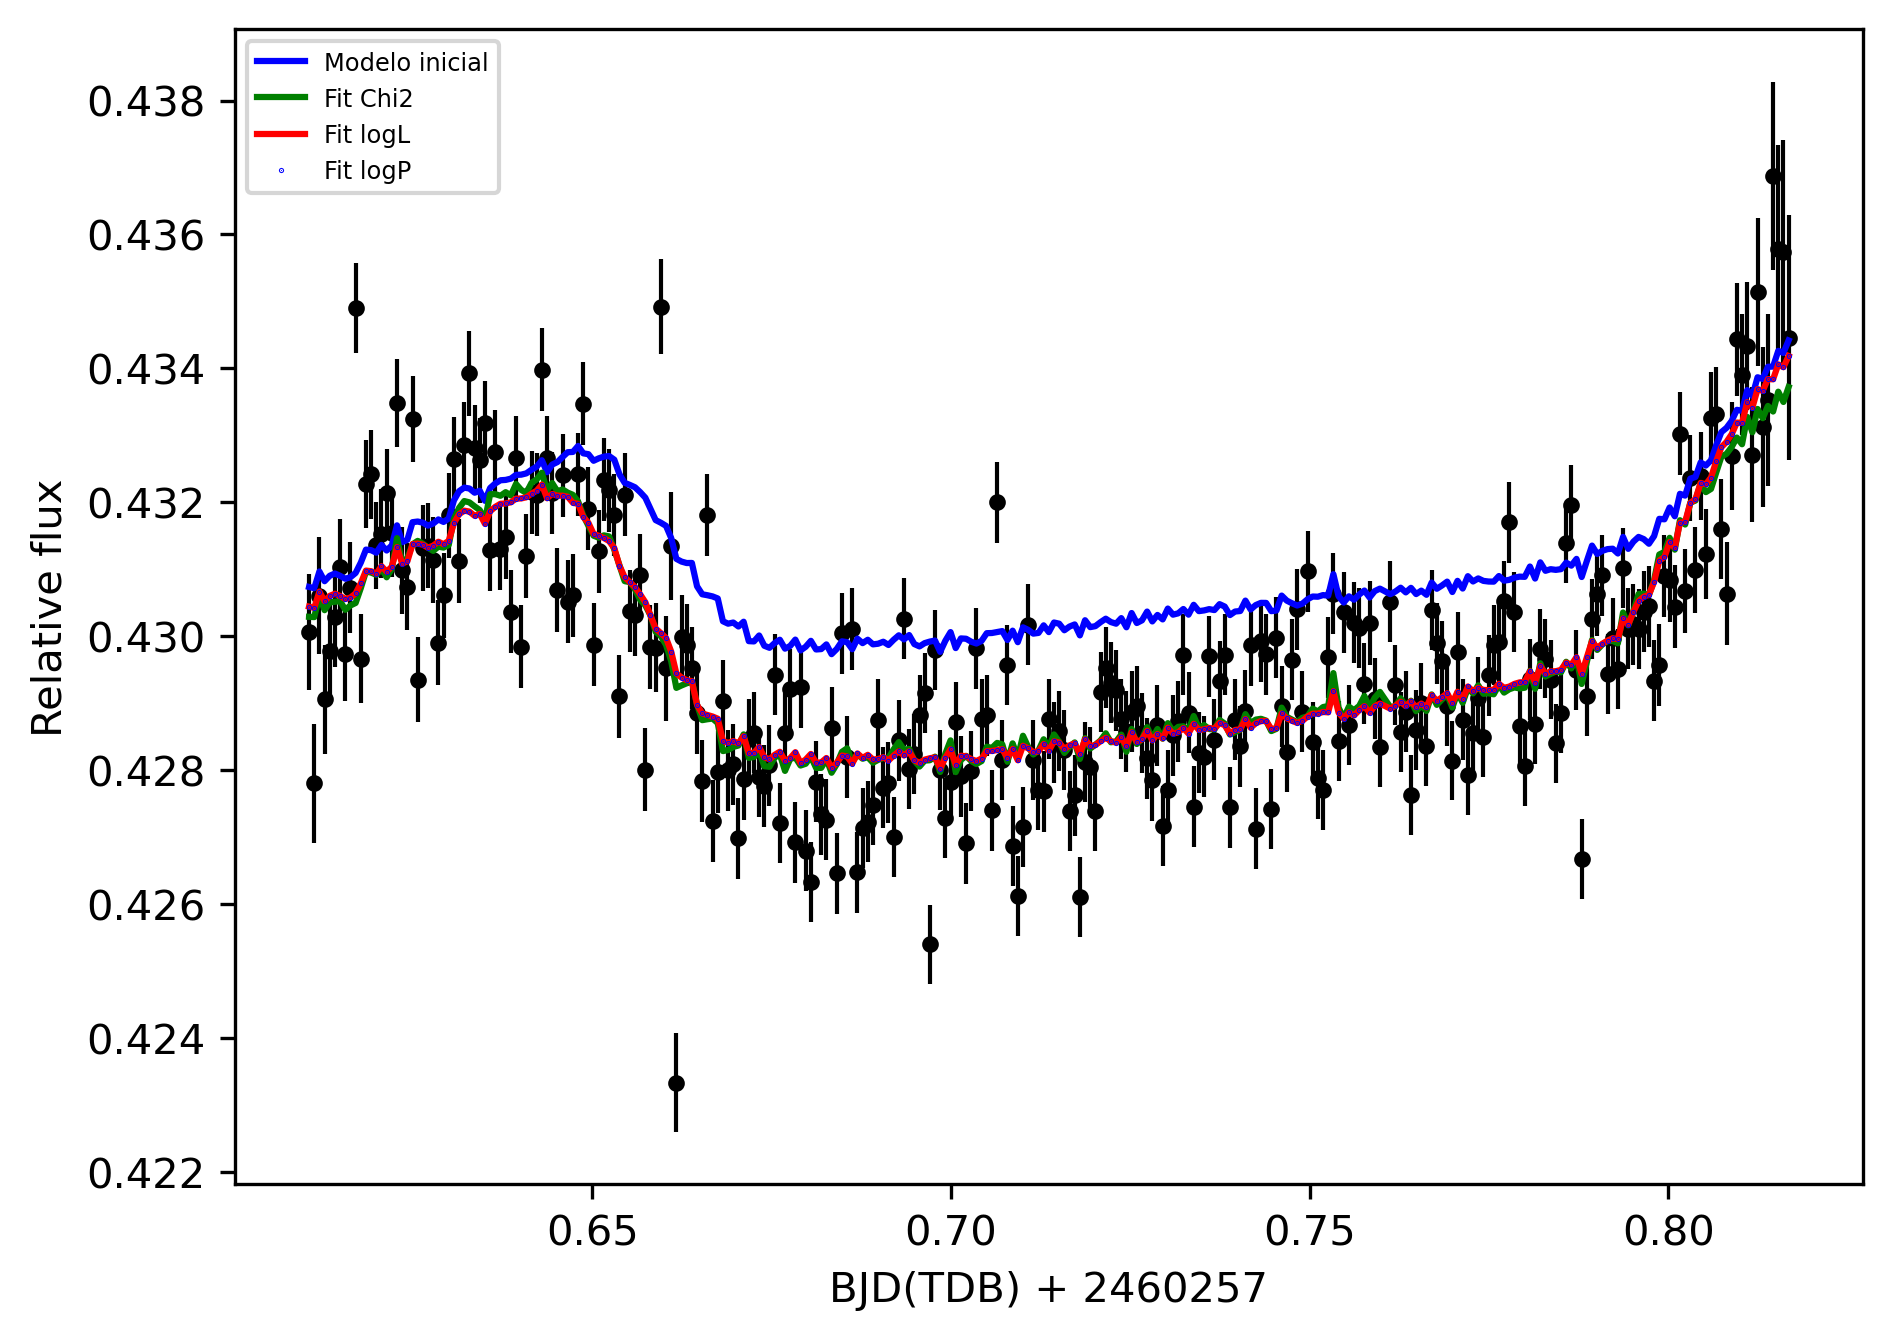

In [18]:
p_chi2 = fminmax(chi2, p, err=e, args=(transit_ldquad, time, flux, dflux), min=True)
p_logL = fminmax(logL, p, err=e, args=(transit_ldquad, time, flux, dflux), min=False)
p_logP = fminmax(logP, p, err=e, args=(transit_ldquad, time, flux, dflux), min=False)
# 3 formas de hacer lo mismo:
model_chi2 = transit_ldquad(p_chi2, time)
model_logL = transit_ldquad(p_logL, time)
model_logP = transit_ldquad(p_logP, time)
fig1 = plt.figure(figsize=(7,5))
ax0 = fig1.add_subplot()
ax0.errorbar(time,flux, yerr=dflux, fmt='o', color='black', capsize=0, ms=3, lw=1, zorder=0)
#ax0.plot(time_model, model_flux, '-r')
ax0.plot(time, model_flux, '-b', label="Modelo inicial")
ax0.plot(time, model_chi2, '-g', label="Fit Chi2")
ax0.plot(time, model_logL, '-r', label="Fit logL")
ax0.plot(time, model_logP, '.b', markersize=0.5, label="Fit logP")
ax0.legend(fontsize='xx-small')
ax0.set_xlabel("BJD(TDB) + %.0f"%t0)
ax0.set_ylabel("Relative flux")
plt.savefig(PATH+"/fig2_fit_min_chi2.png", dpi=300)

Con esto podemos ver los parámetros:

In [19]:
for i in range(len(e)):
    print("%5s = %10.6f (initial %10.6f)"%(p_names[i], p_chi2[i], p[i]))

   rp =   0.115982 (initial   0.099800)
  per = 225.117810 (initial 225.117810)
    a = 147.400000 (initial 147.400000)
  inc =  89.060000 (initial  89.060000)
   t0 =   0.731035 (initial   0.735000)
  ecc =   0.760000 (initial   0.760000)
    w =  60.000000 (initial  60.000000)
   u1 =   0.280000 (initial   0.280000)
   u2 =   0.290000 (initial   0.290000)
   f0 =   0.305121 (initial   0.333500)
f_secz =  -0.003725 (initial  -0.004600)
f_fwhm =   0.000105 (initial   0.000021)
 f_xc =  -0.000033 (initial   0.000012)
 f_yc =   0.000201 (initial   0.000140)


***
MCMC fitting
***

In [20]:
def chi2_mcmc(p,model,x,y,sig):
  return num.sum(((y - model) / sig)**2)
                 
def logL_mcmc(p,model,x,y,sig):
  return -0.5*chi2_mcmc(p,model,x,y,sig) - num.log(sig).sum()

# We can also create a simple uniform posterior distribution by limiting the parameter space
def logP_mcmc(p,*args):
  if p[0] < 0 or p[0] > 1: return -num.inf
  if p[1] < 0: return -num.inf
  if p[2] < 0: return -num.inf
  if FIT_b:
    if p[3] < 0 or p[3] > 1: return -num.inf
  else:
    if p[3] < 0 or p[3] > 90.0: return -num.inf
  if p[7] < 0: return -num.inf
  if p[8] < 0: return -num.inf
  return logL_mcmc(p,*args)


In [21]:
def log_prob_mcmc(pvar, x, y, yerr, p0, idx_var):
    pin = num.copy(p0)
    pin[idx_var] = pvar
    model = transit_ldquad(pin, x)
    return logP_mcmc(pin, model, x, y, yerr)

In [22]:
idx_var = e > 0
pos = p[idx_var] + 1.0e-3*num.random.randn(MCMC_nwalkers, len(p[idx_var]))
nwalkers, ndim = pos.shape
if PAR:
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_mcmc, pool=pool, args=(time, flux, dflux, p, idx_var))
        sampler.run_mcmc(pos, MCMC_nsteps, progress=True)
else:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_mcmc, args=(time, flux, dflux, p, idx_var))#, pool=pool)
    sampler.run_mcmc(pos, MCMC_nsteps, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [08:14<00:00, 80.83it/s]


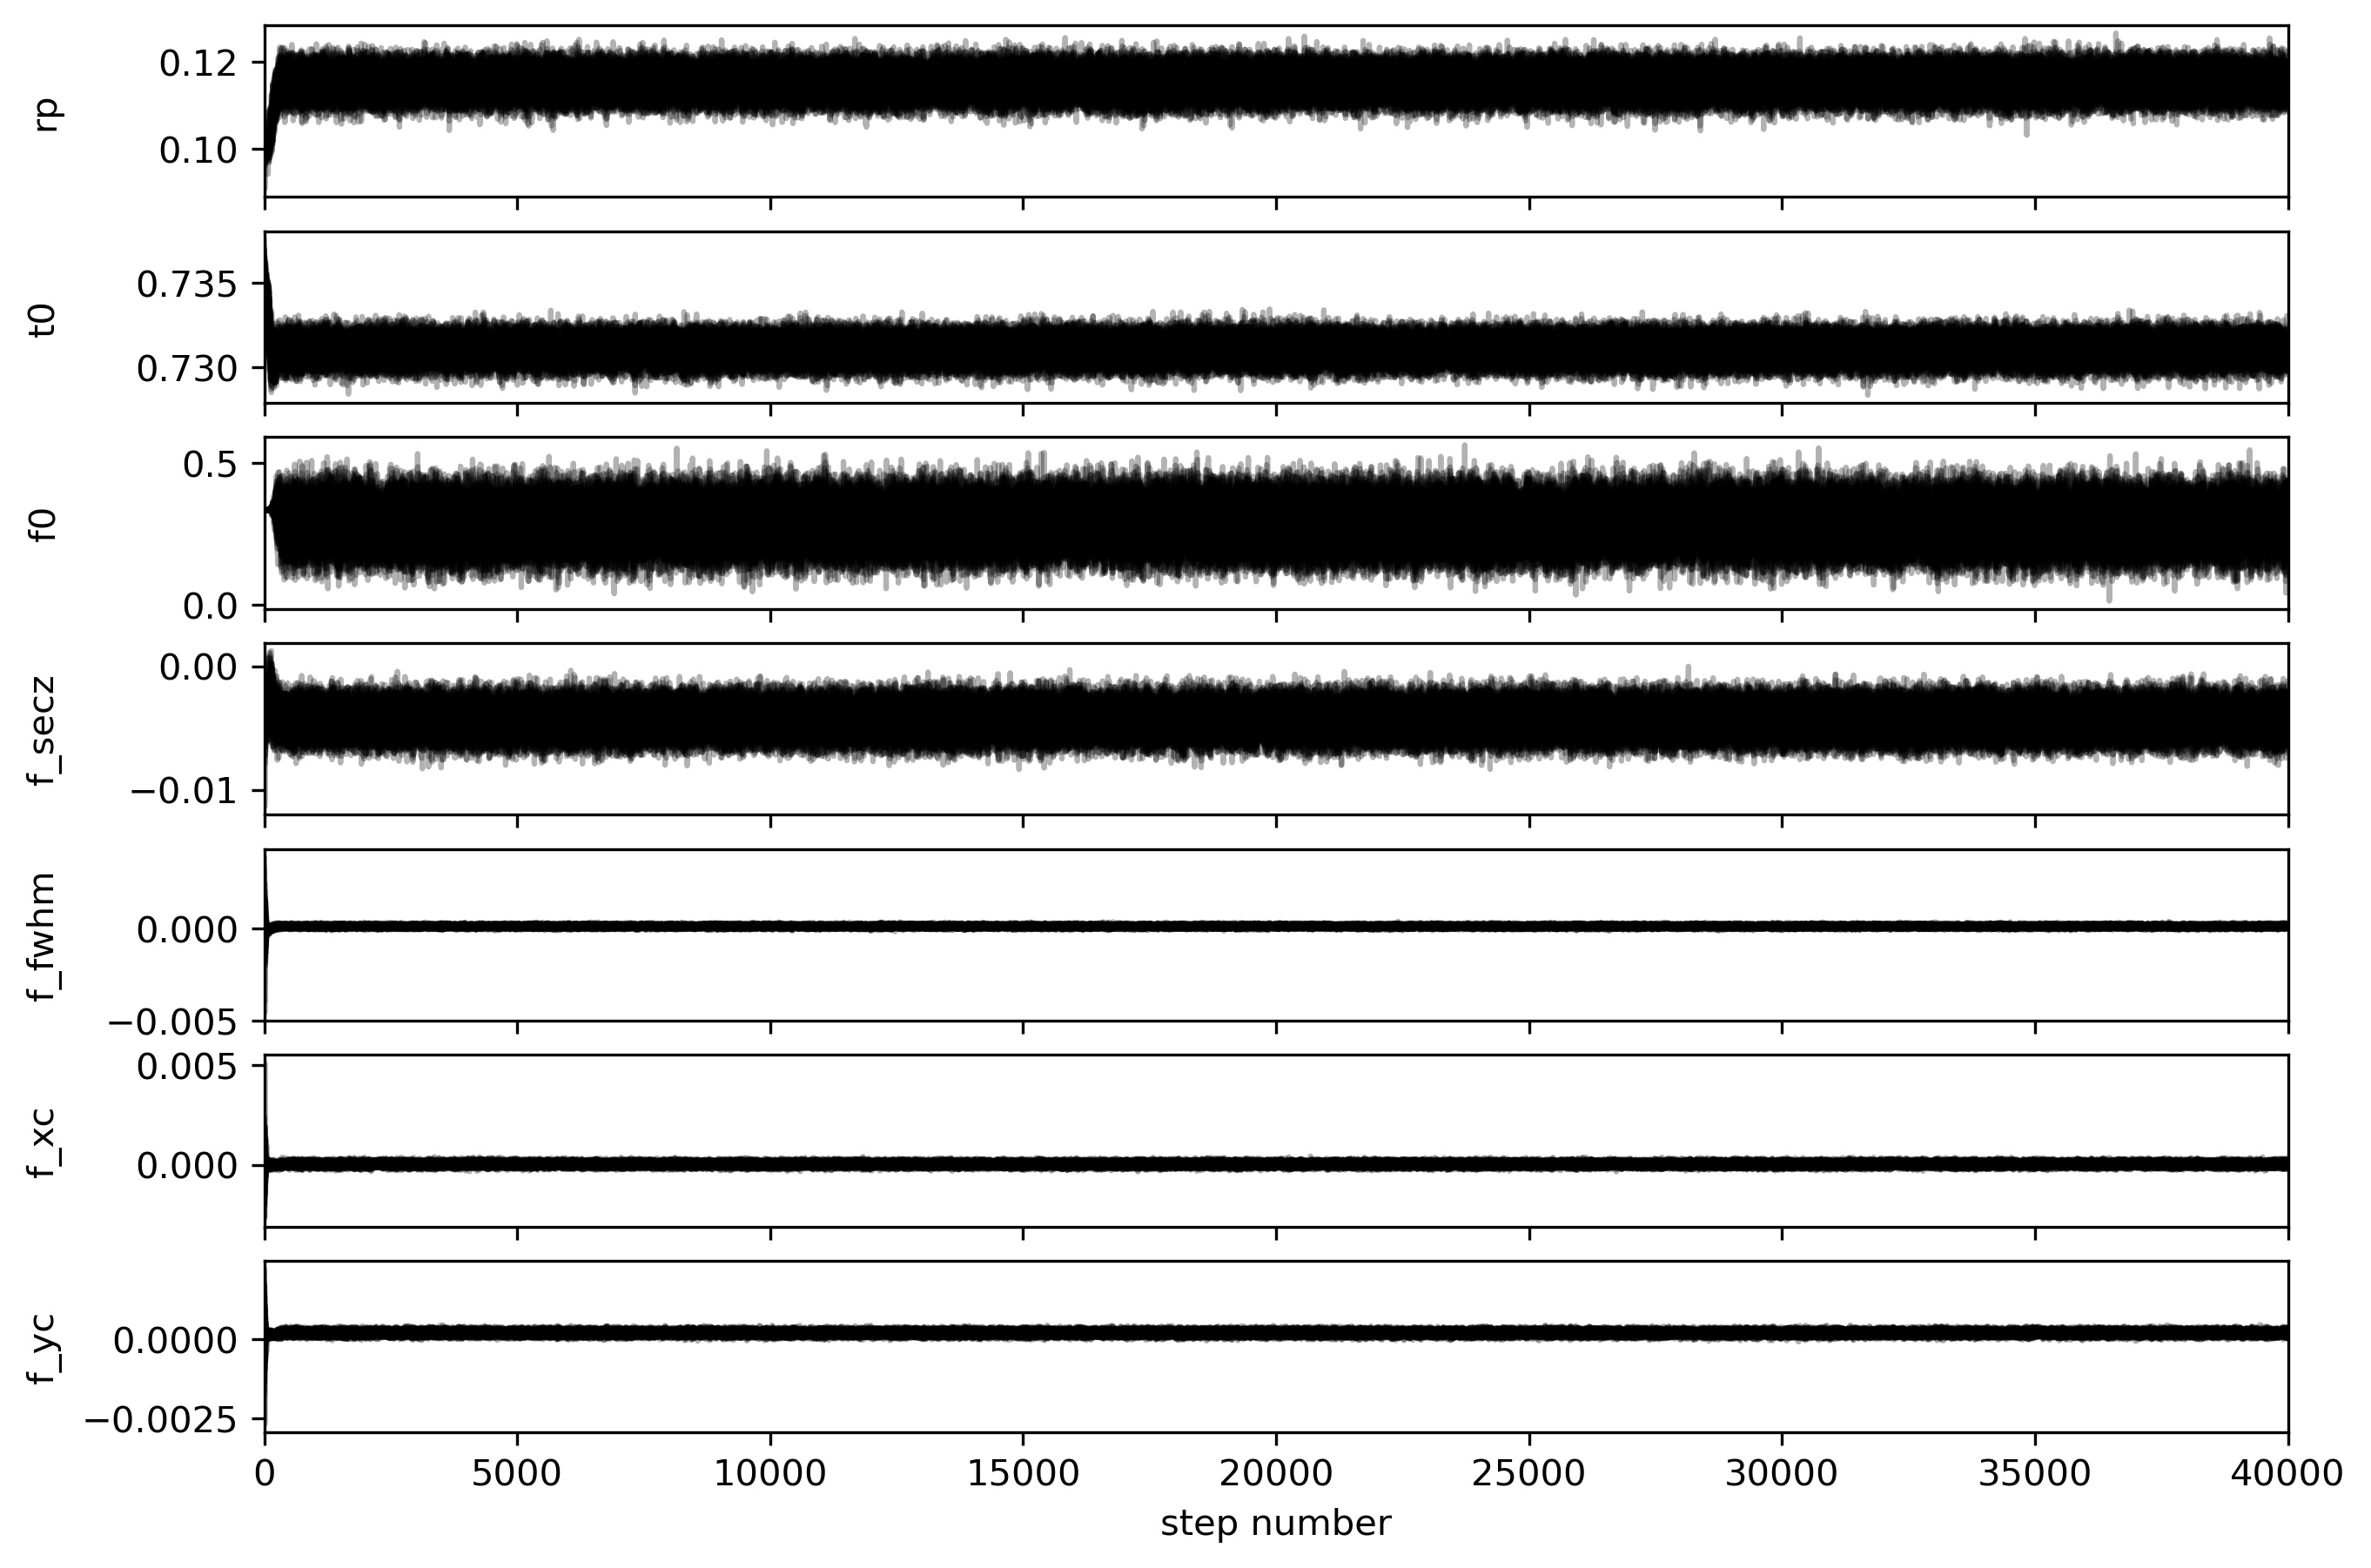

In [23]:
npanels = len(p[idx_var])
fig, axes = plt.subplots(npanels, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = num.array(p_names)[idx_var]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.savefig(PATH+"/fig3_mcmc_chains.png", dpi=300)

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

[97.23146168 76.30564511 78.49533102 78.68304067 76.04542982 72.42918927
 77.2868068 ]


In [25]:
flat_samples = sampler.get_chain(discard=MCMC_burnin, thin=int(MCMC_nwalkers/2), flat=True)
print(flat_samples.shape)

(59968, 7)


In [26]:
for i in range(len(e)):
    print("%5s = %10.6f (initial %10.6f)"%(p_names[i], p_chi2[i], p[i]))

   rp =   0.115982 (initial   0.099800)
  per = 225.117810 (initial 225.117810)
    a = 147.400000 (initial 147.400000)
  inc =  89.060000 (initial  89.060000)
   t0 =   0.731035 (initial   0.735000)
  ecc =   0.760000 (initial   0.760000)
    w =  60.000000 (initial  60.000000)
   u1 =   0.280000 (initial   0.280000)
   u2 =   0.290000 (initial   0.290000)
   f0 =   0.305121 (initial   0.333500)
f_secz =  -0.003725 (initial  -0.004600)
f_fwhm =   0.000105 (initial   0.000021)
 f_xc =  -0.000033 (initial   0.000012)
 f_yc =   0.000201 (initial   0.000140)


[0.11541014845971277, 0.7310491262364809, 0.2870427324221751, -0.004324804801054101, 0.00013081377341003423, 2.930952365361004e-05, 0.00019003333090541468]
[ 1.15410148e-01  2.25117810e+02  1.47400000e+02  8.90600000e+01
  7.31049126e-01  7.60000000e-01  6.00000000e+01  2.80000000e-01
  2.90000000e-01  2.87042732e-01 -4.32480480e-03  1.30813773e-04
  2.93095237e-05  1.90033331e-04]


Text(0, 0.5, 'Relative flux')

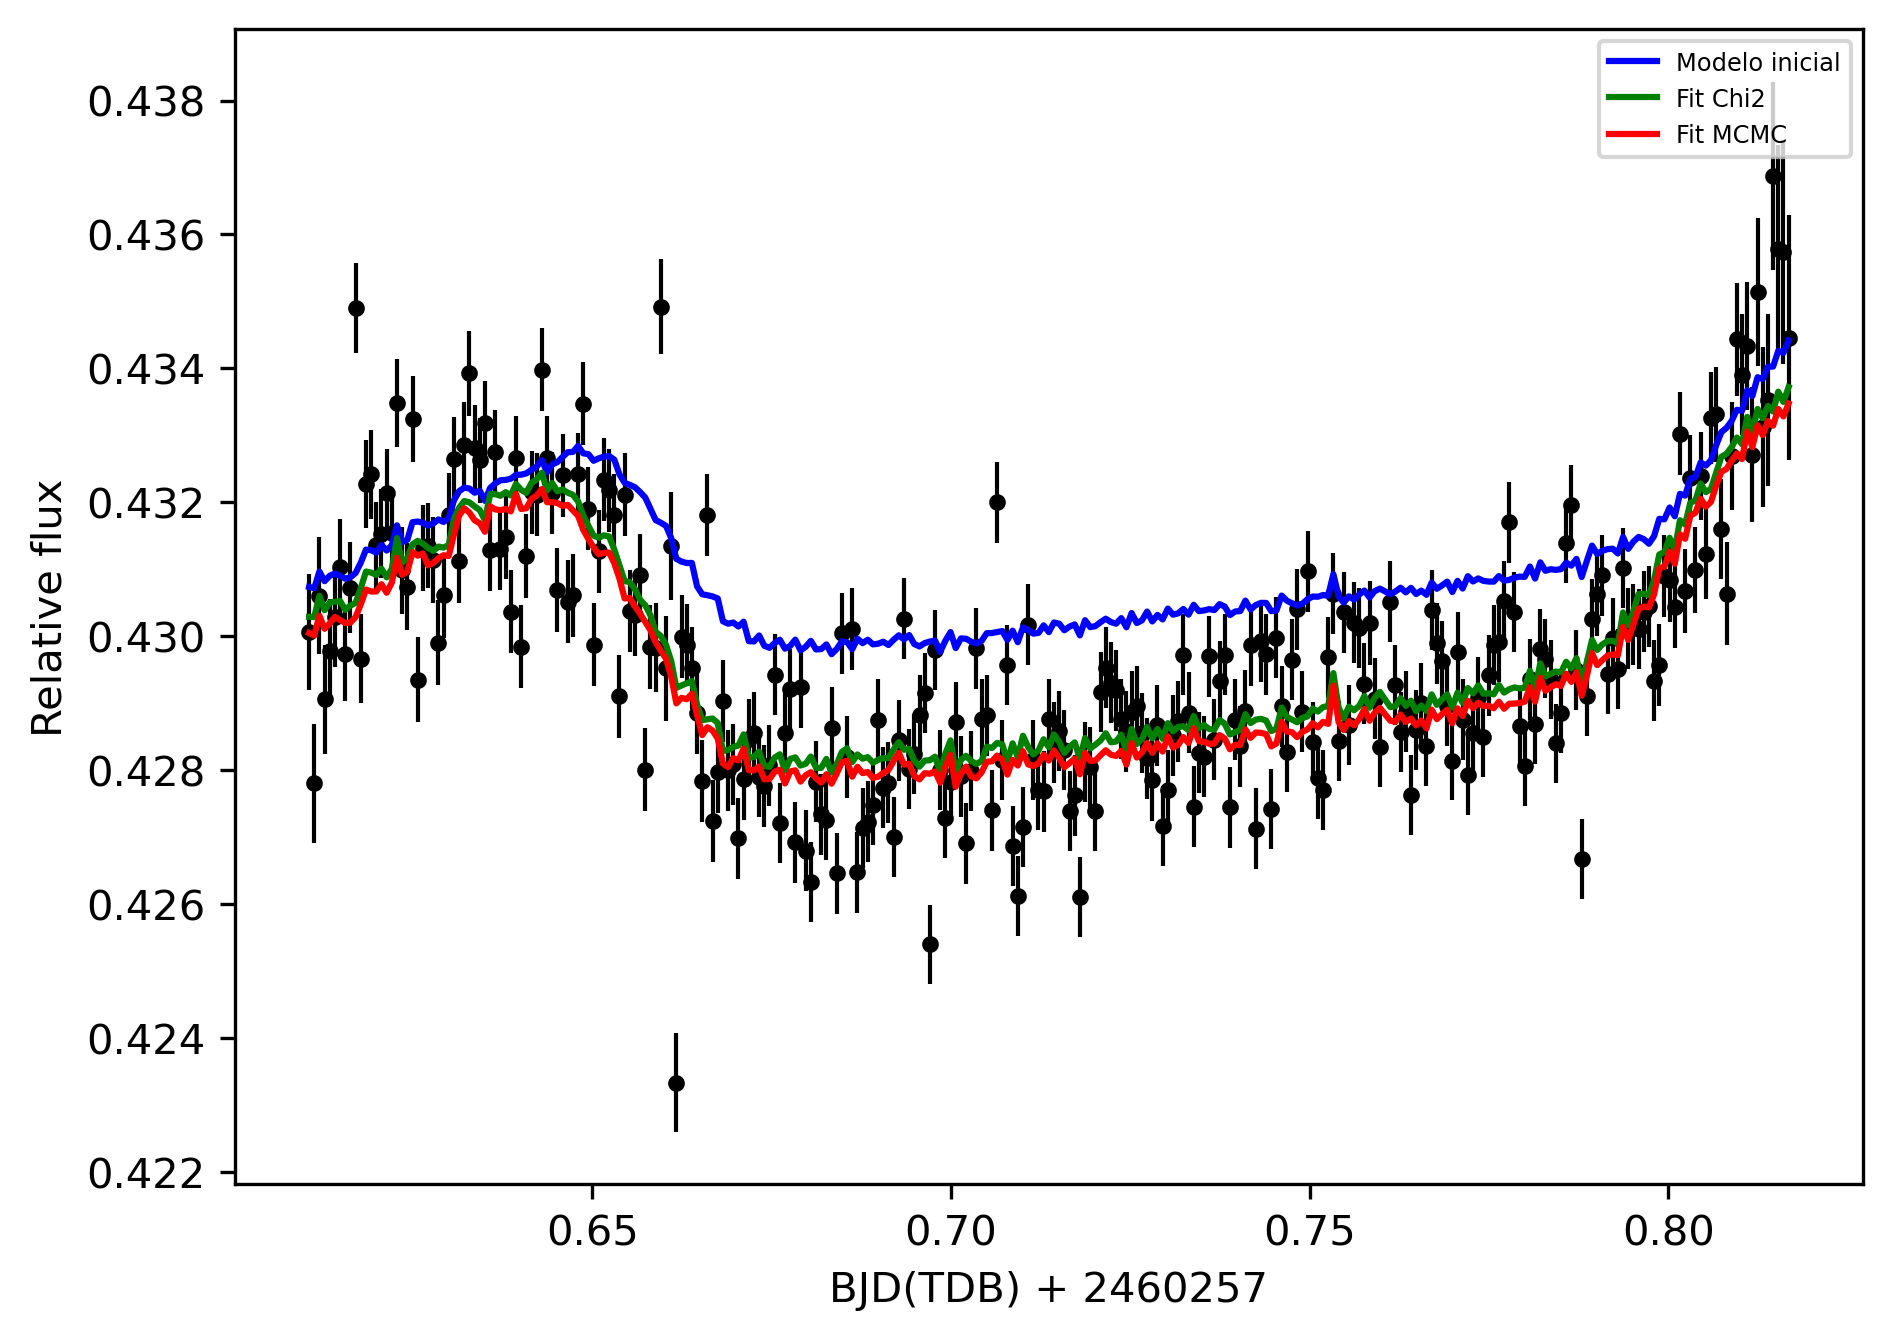

In [27]:
p_var_mcmc = []
for i in range(ndim):
    mcmc = num.percentile(flat_samples[:, i], [16, 50, 84])
    p_var_mcmc.append(mcmc[1])
print(p_var_mcmc)
p_mcmc = num.copy(p)
p_mcmc[idx_var] = p_var_mcmc
print(p_mcmc)
# Realizar el fit sólo sobre parámetros con e > 0
model_chi2 = transit_ldquad(p_chi2, time)
model_mcmc = transit_ldquad(p_mcmc, time)
fig1 = plt.figure(figsize=(7,5))
ax0 = fig1.add_subplot()
ax0.errorbar(time,flux, yerr=dflux, fmt='o', color='black', capsize=0, ms=3, lw=1, zorder=0)
ax0.plot(time, model_flux, '-b', label="Modelo inicial")
ax0.plot(time, model_chi2, '-g', label="Fit Chi2")
ax0.plot(time, model_mcmc, '-r', label="Fit MCMC")
ax0.legend(fontsize='xx-small')
ax0.set_xlabel("BJD(TDB) + %.0f"%t0)
ax0.set_ylabel("Relative flux")

In [28]:
for i in range(len(e)):
    print("%5s = %10.6f (initial %10.6f)"%(p_names[i], p_mcmc[i], p[i]))

   rp =   0.115410 (initial   0.099800)
  per = 225.117810 (initial 225.117810)
    a = 147.400000 (initial 147.400000)
  inc =  89.060000 (initial  89.060000)
   t0 =   0.731049 (initial   0.735000)
  ecc =   0.760000 (initial   0.760000)
    w =  60.000000 (initial  60.000000)
   u1 =   0.280000 (initial   0.280000)
   u2 =   0.290000 (initial   0.290000)
   f0 =   0.287043 (initial   0.333500)
f_secz =  -0.004325 (initial  -0.004600)
f_fwhm =   0.000131 (initial   0.000021)
 f_xc =   0.000029 (initial   0.000012)
 f_yc =   0.000190 (initial   0.000140)


[ 1.15410148e-01  7.31049126e-01  2.87042732e-01 -4.32480480e-03
  1.30813773e-04  2.93095237e-05  1.90033331e-04]


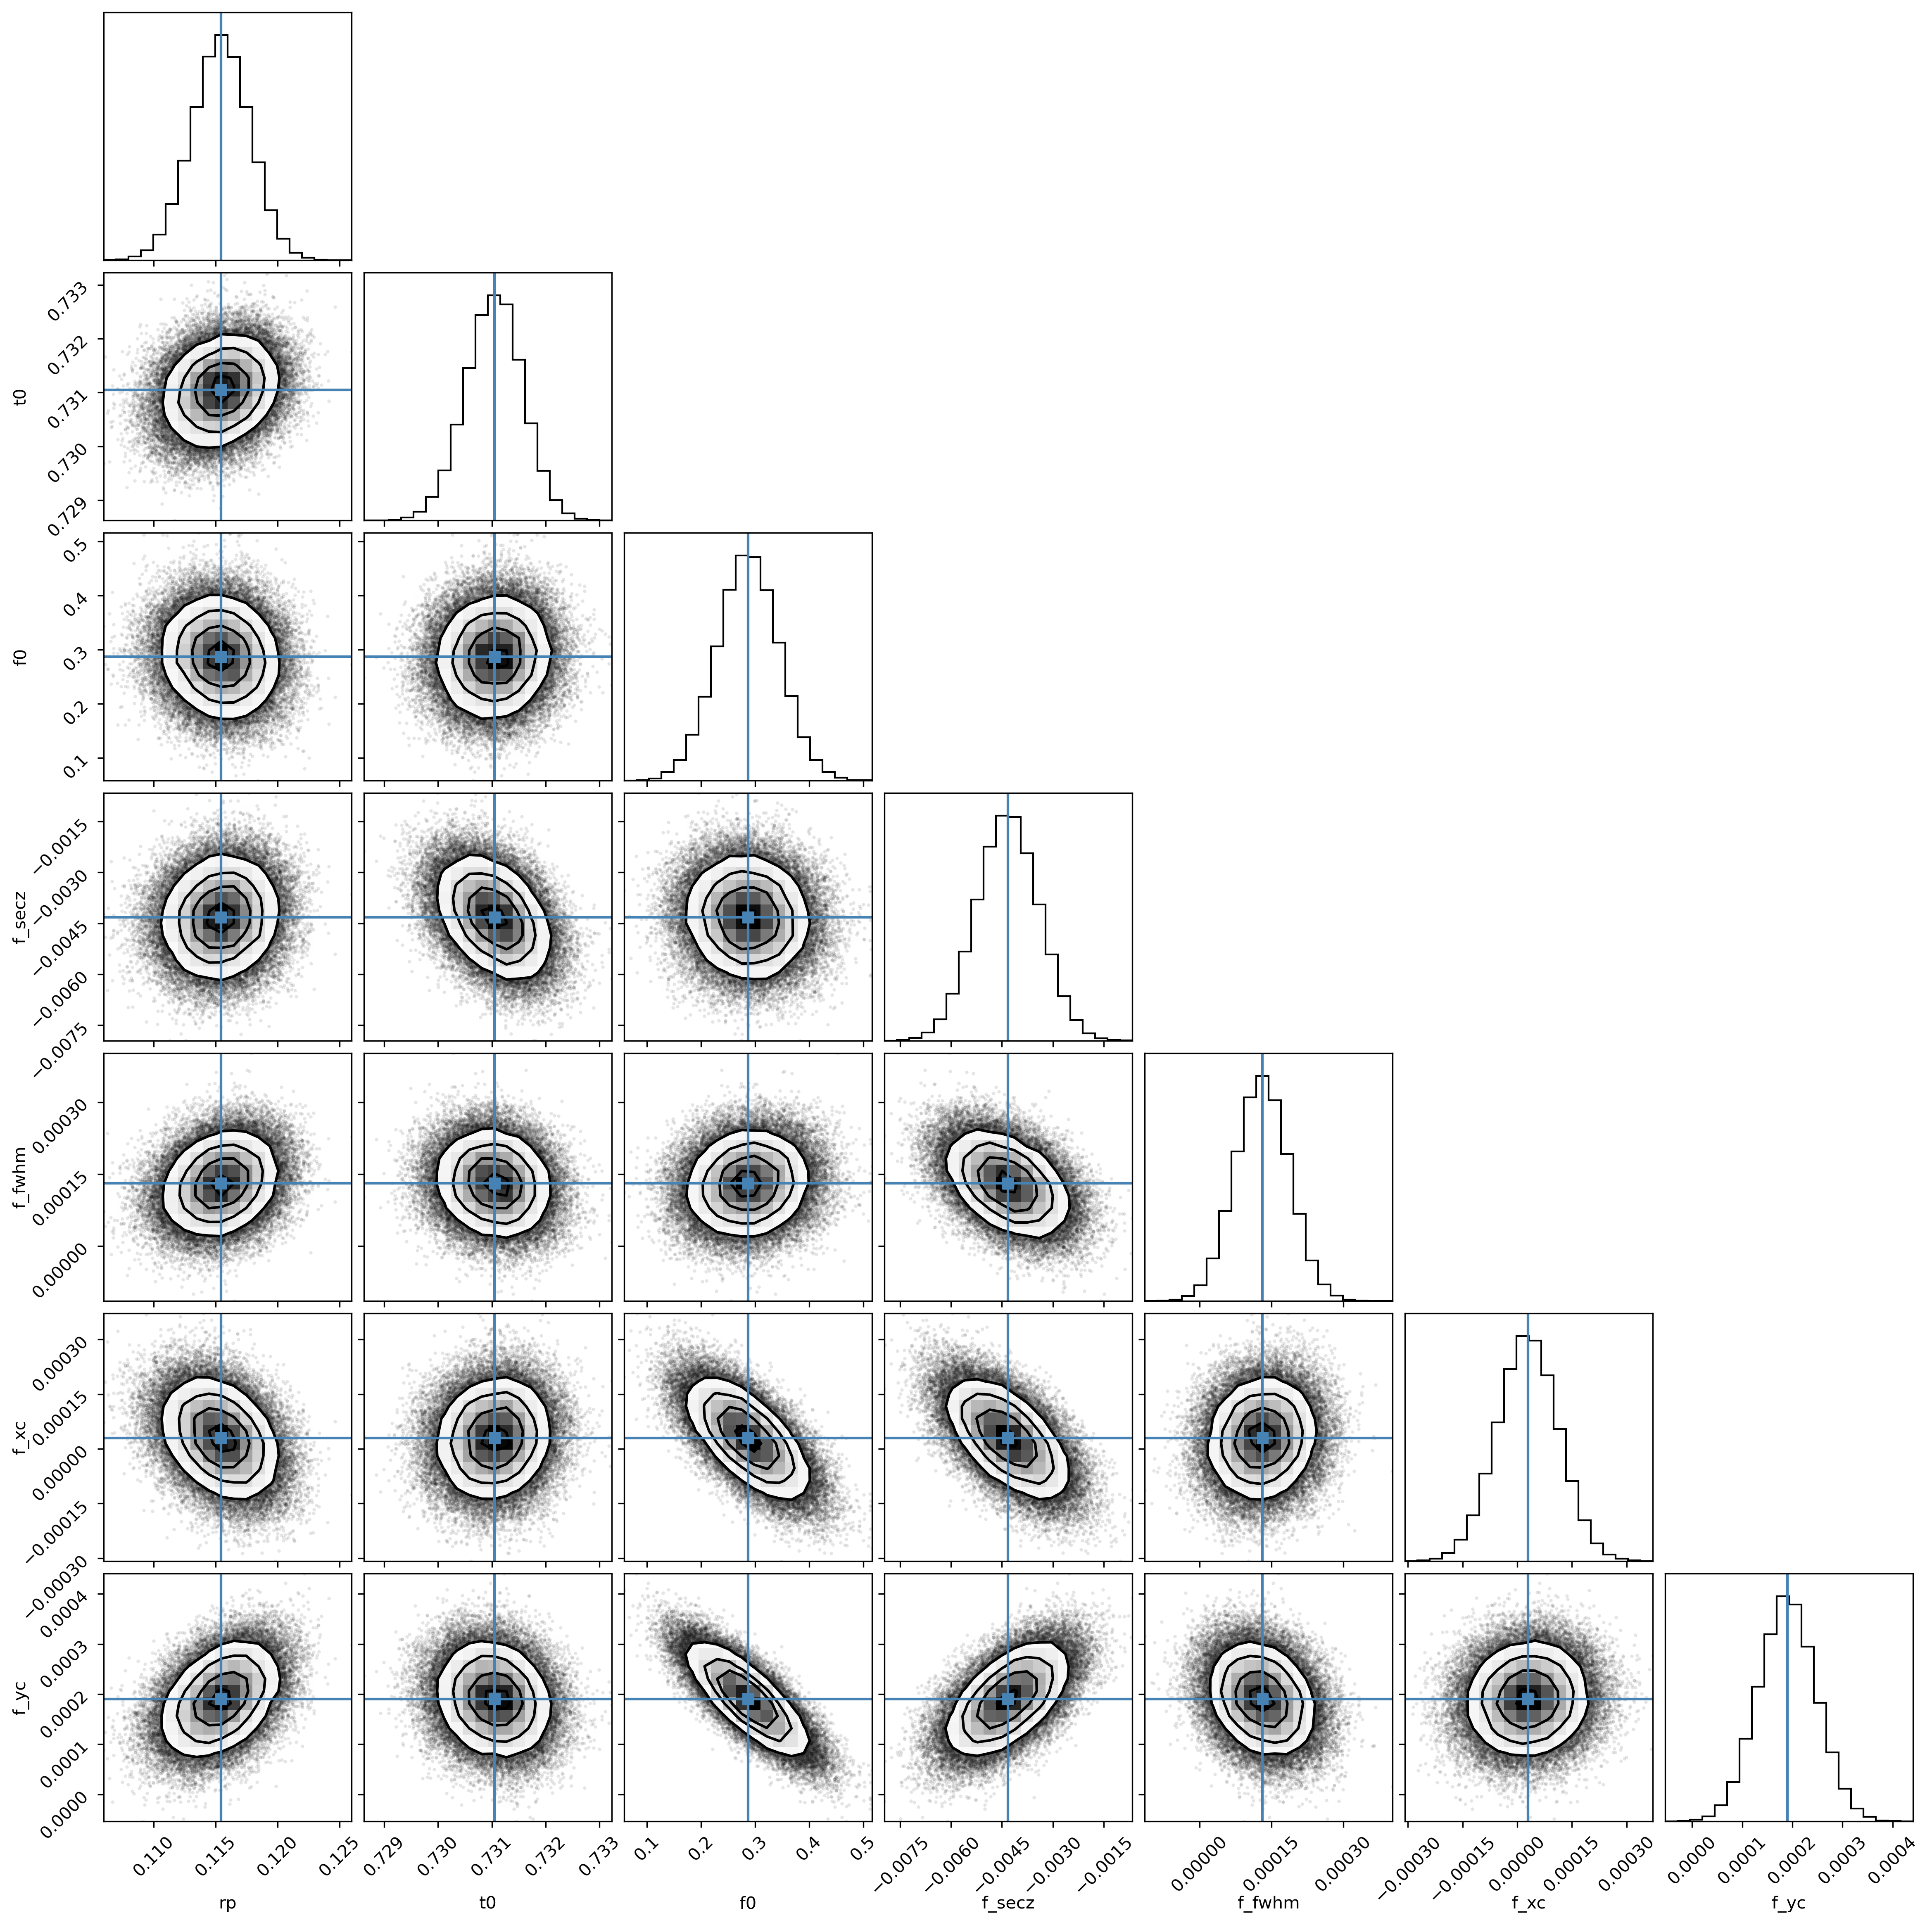

In [29]:
true_values = num.array(p_mcmc)[idx_var]
print(true_values)
fig = corner.corner(flat_samples, labels=labels, truths=true_values)
plt.savefig(PATH+"/fig4_mcmc_corner.png", dpi=300)

In [30]:
from IPython.display import display, Math
foutput = open(PATH+"/mcmc_fit.txt", 'w')
for i in range(ndim):
    mcmc = num.percentile(flat_samples[:, i], [16, 50, 84])
    q = num.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    txto = "%10s = %+10.5f +%7.5f -%7.5f\n"%(labels[i],mcmc[1], q[0], q[1])
    foutput.write(txto)
    display(Math(txt))
foutput.close()


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

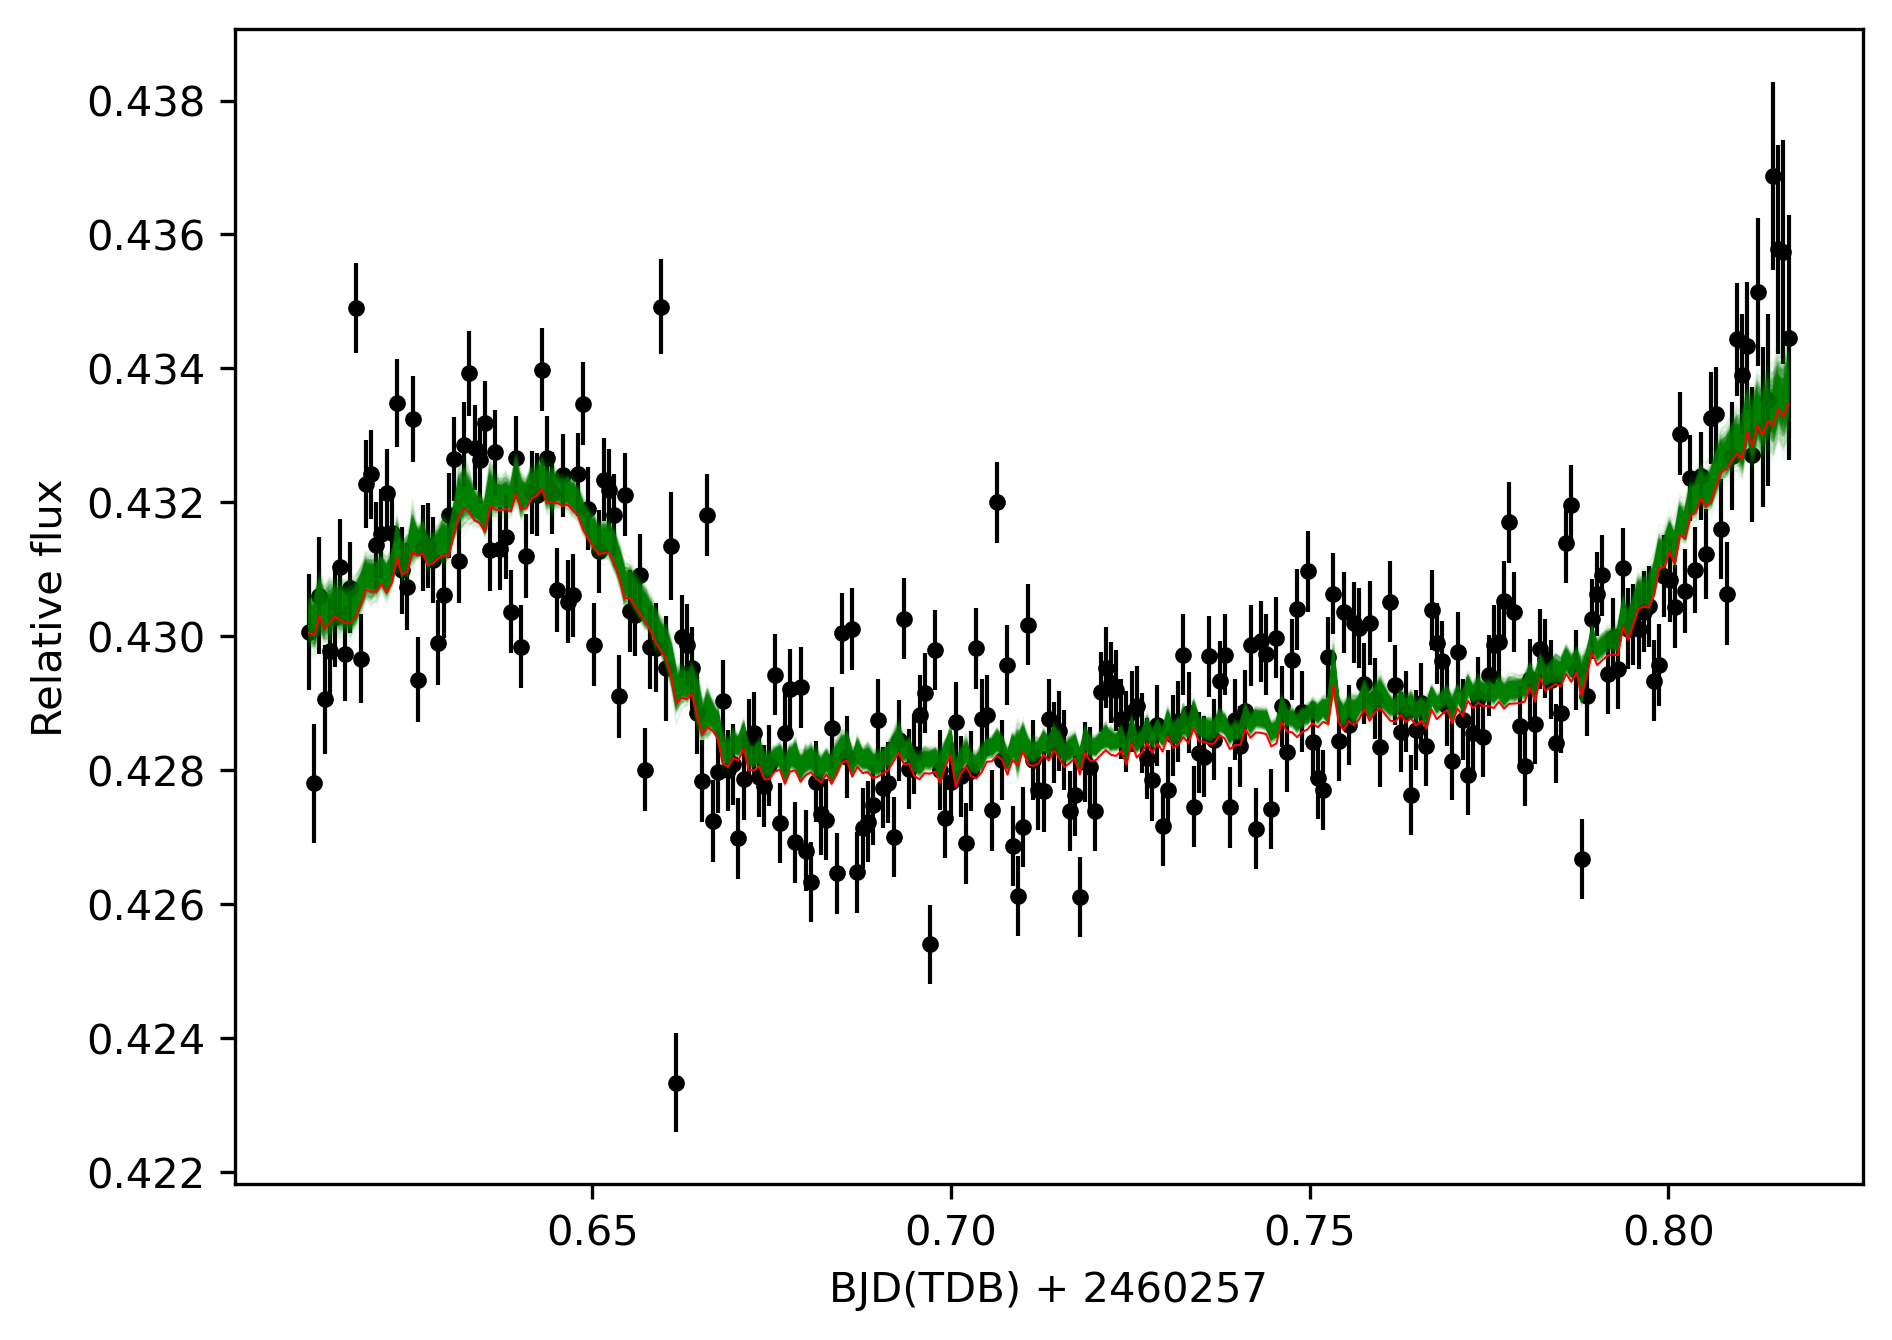

In [31]:
fig1 = plt.figure(figsize=(7,5))
ax0 = fig1.add_subplot()
nplots = int((MCMC_nsteps - MCMC_burnin)/MCMC_nwalkers*2)
nsamples = len(flat_samples)
idx_to_plot = num.random.randint(low=int(nsamples/2), high=nsamples, size=nplots)
p_mcmc_temp = num.copy(p)
ax0.errorbar(time,flux, yerr=dflux, fmt='o', color='black', capsize=0, ms=3, lw=1, zorder=0)
for i in range(nplots):
    j = idx_to_plot[i]
    p_mcmc_temp[idx_var] = flat_samples[j,:]
    ax0.plot(time, transit_ldquad(p_mcmc_temp, time), '-g', linewidth=0.5, alpha=0.05)
ax0.plot(time, model_mcmc, '-r', linewidth=0.5)
ax0.set_xlabel("BJD(TDB) + %.0f"%t0)
ax0.set_ylabel("Relative flux")

plt.savefig(PATH+"/fig5_mcmc_fit.png", dpi=300)


226.09544127283544


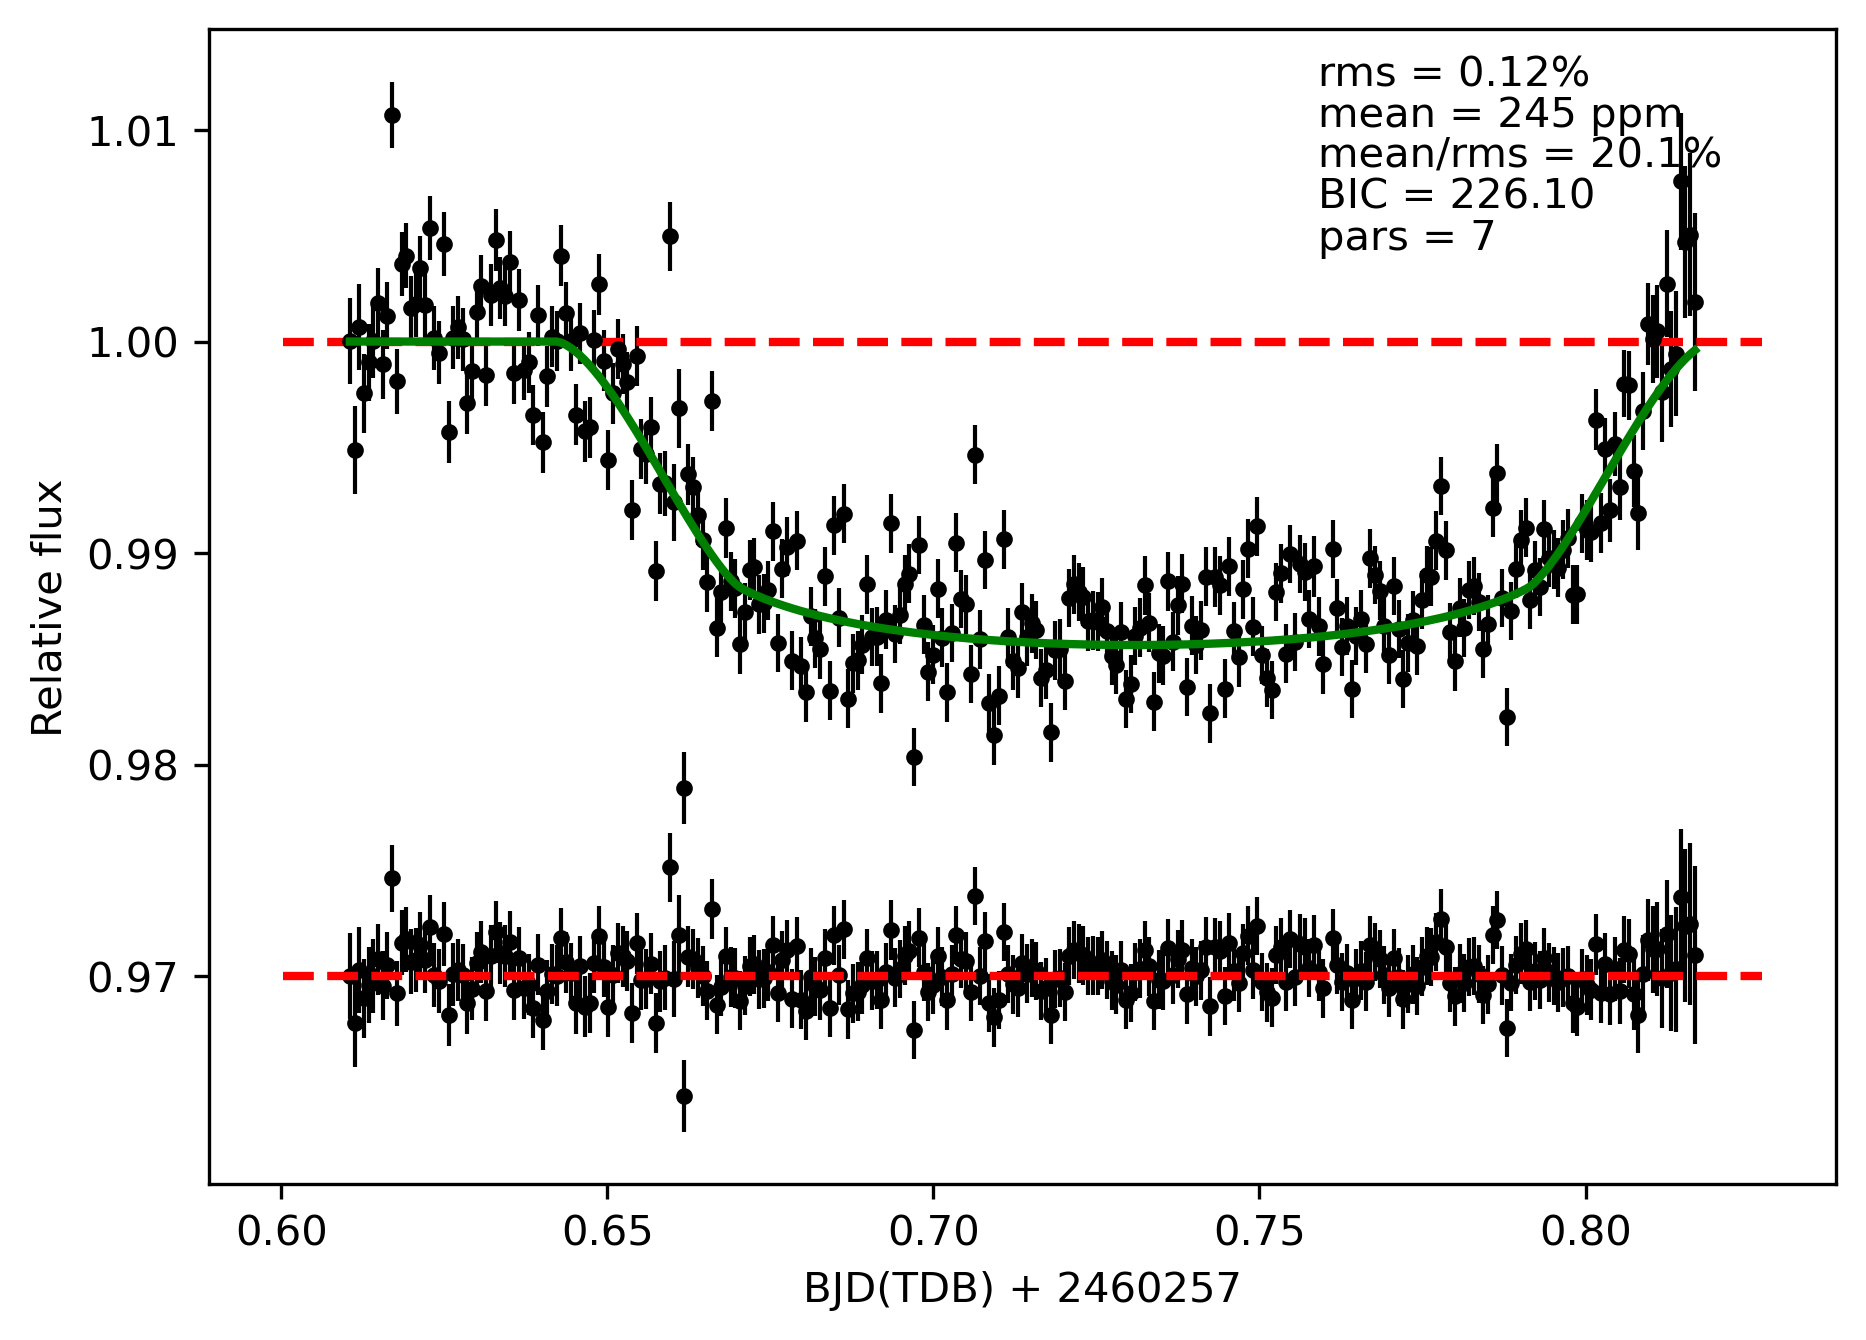

In [32]:
fig1 = plt.figure(figsize=(7,5))
ax0 = fig1.add_subplot()
baseline = model_baseline(p_mcmc, time)
flux_norm = flux / baseline
dflux_norm = dflux / baseline
transit_model_mcmc = model_transit(p_mcmc, time)
residual = flux - transit_ldquad(p_mcmc, time)
zline = 0.97

ax0.errorbar(time,flux_norm, yerr=dflux_norm, fmt='o', color='black', capsize=0, ms=3, lw=1, zorder=0)
x0,x1 = ax0.get_xlim()
y0,y1 = ax0.get_ylim()

ax0.errorbar(time,residual+zline, yerr=dflux_norm, fmt='o', color='black', capsize=0, ms=3, lw=1, zorder=0)
ax0.plot(time, transit_model_mcmc, '-g', linewidth=2)
ax0.set_xlabel("BJD(TDB) + %.0f"%t0)
ax0.set_ylabel("Relative flux")
ax0.plot([x0,x1], [1.0,1.0], '--r', lw=2, zorder=0)
ax0.plot([x0,x1], [zline,zline], '--r', lw=2, zorder=1)

res_rms = num.sqrt(mean_squared_error(residual, residual*0.0))
bic_k = len(true_values)
bic_n = len(residual)
bic_chi2 = (residual**2/dflux_norm**2).sum()
BIC = bic_k*num.log(bic_n) + bic_chi2
print(BIC)
fx = 0.7
fy = 0.95
ax0.text(x0*(1-fx) + x1*fx, y0*(1-fy) + y1*fy, "rms = %.2f%%"%(res_rms*100.0))
fx = 0.7
fy = 0.90
ax0.text(x0*(1-fx) + x1*fx, y0*(1-fy) + y1*fy, "mean = %.0f ppm"%(1.0e6*residual.mean()))
fx = 0.7
fy = 0.85
ax0.text(x0*(1-fx) + x1*fx, y0*(1-fy) + y1*fy, "mean/rms = %.1f%%"%(residual.mean()/res_rms*100))
fx = 0.7
fy = 0.80
ax0.text(x0*(1-fx) + x1*fx, y0*(1-fy) + y1*fy, "BIC = %.2f"%(BIC))
fx = 0.7
fy = 0.75
ax0.text(x0*(1-fx) + x1*fx, y0*(1-fy) + y1*fy, "pars = %d"%(bic_k))

plt.savefig(PATH+"/fig6_mcmc_residuals_fit.png", dpi=300)